In [163]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
#%pip install xgboost
import xgboost as xgb
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import RandomizedSearchCV,cross_val_predict


In [48]:
df = pd.read_csv("0131_2.csv")
df2 = pd.read_csv("0131_3.csv")
df = pd.concat([df,df2], axis=0)
#for i in range(2,16):
#    partialDF = pd.read_csv(f"{i}.csv", header=None)
#    df = pd.concat([df,partialDF],ignore_index=True, axis=0)
df

,MagX1,MagY1,MagZ1,AccX1,AccY1,AccZ1,MagX2,MagY2,MagZ2,Class
0,-0.39,0.31,-0.20,119.63,615.72,797.36,-1.56,1.06,-2.53,1
1,0.66,-0.14,-1.10,118.16,644.04,757.32,-1.86,2.71,-3.88,1
2,-1.14,0.76,-0.20,117.68,626.46,792.48,-0.36,0.61,-2.23,1
3,0.21,-0.14,1.30,124.51,626.95,765.14,-0.66,1.96,-2.83,1
4,-0.39,-0.44,-1.40,125.00,637.70,762.21,0.24,1.21,-3.58,1
...,...,...,...,...,...,...,...,...,...,...
245,0.16,0.10,-0.31,125.00,618.16,777.34,0.32,-1.49,-0.25,1
246,0.76,-0.50,-0.91,134.77,640.14,775.88,1.22,-0.74,-0.55,1
247,0.46,0.70,-0.61,136.23,626.95,779.30,0.77,-0.44,0.20,1
248,-0.29,0.10,-1.21,128.91,629.88,785.64,1.37,-2.39,-1.15,1


In [145]:
#https://www.geeksforgeeks.org/random-forest-classifier-using-scikit-learn/
#The general setup for the model is here
y = df['Class'].to_numpy()
print(df.columns)
#df = df.drop("Class", axis=1, errors="ignore")
X = df[df.columns[0:-1]].to_numpy()
X = StandardScaler().fit_transform(X)
train_size = 0.8
test_size = 1-train_size
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, test_size = test_size, random_state=42)
print("test\\train splitting complete")
print(f"Training: {len(X_train)}, Testing: {len(X_test)}")
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y = le.fit_transform(y)

Index(['MagX1', 'MagY1', 'MagZ1', 'AccX1', 'AccY1', 'AccZ1', 'MagX2', 'MagY2',
       'MagZ2', 'Class'],
      dtype='object')
test\train splitting complete
Training: 360, Testing: 90


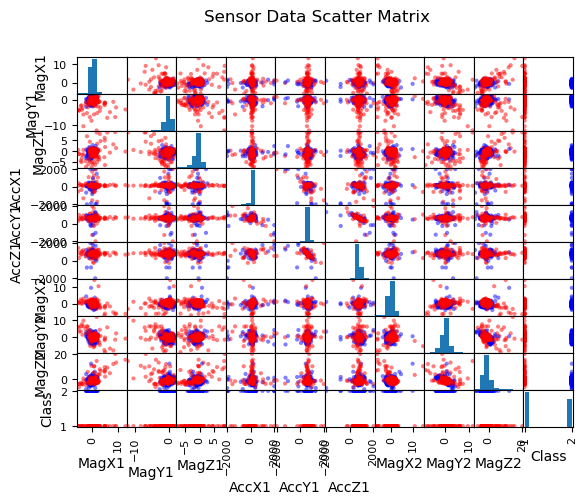

In [166]:
colorMap = {1: 'red', 2: 'blue'}
colors = [colorMap[label] for label in df['Class']]
_ = pd.plotting.scatter_matrix(df, color=colors)
plt.suptitle("Sensor Data Scatter Matrix")
plt.show()

In [153]:
randomForestClassifier = RandomForestClassifier(n_estimators = 150, criterion="gini", max_features="sqrt", random_state=42)
#Best params from GridSearch: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'sampling_method': 'uniform', 'subsample': 0.5}
#Best params from RandomSearch: {'colsample_bytree': 0.855325405158244, 'gamma': 0.418855052953664, 'learning_rate': 0.2127070351117842, 'max_depth': 2, 'n_estimators': 227}
xgb_clf = xgb.XGBClassifier(n_estimators=227, learning_rate=0.2127070351117842, max_depth=2, random_state=42, gamma=0.418855052953664, colsample_bytree=0.855325405158244)

print("Fitting models")
randomForestClassifier.fit(X, y)
xgb_clf.fit(X, y)
print("Model fitting complete")


Fitting models
Model fitting complete


In [158]:
#APR Reference: https://stackoverflow.com/questions/31421413/how-to-compute-precision-recall-accuracy-and-f1-score-for-the-multiclass-case
print("Predicting Model")
y_pred_rf = cross_val_predict(randomForestClassifier,X,y,cv=5)
y_pred_xgb =cross_val_predict(xgb_clf,X,y,cv=5)
print("Complete")

Predicting Model
Complete


In [167]:
print("Accuracy RF:", accuracy_score(y, y_pred_rf))
print("F1 Score RF:", f1_score(y, y_pred_rf, average="macro"))
print("Precision RF:", precision_score(y, y_pred_rf, average="macro"))
print("Recall RF:", recall_score(y, y_pred_rf, average="macro"))
print()
print("Accuracy XGB:", accuracy_score(y, y_pred_xgb))
print("F1 Score XGB:", f1_score(y, y_pred_xgb, average="macro"))
print("Precision XGB:", precision_score(y, y_pred_xgb, average="macro"))
print("Recall XGB:", recall_score(y, y_pred_xgb, average="macro"))

Accuracy RF: 0.68
F1 Score RF: 0.6612012715409068
Precision RF: 0.6838235294117647
Recall RF: 0.6619999999999999

Accuracy XGB: 0.6911111111111111
F1 Score XGB: 0.6802327067496203
Precision XGB: 0.6893739023719345
Recall XGB: 0.679


In [149]:
#Sources: https://stackoverflow.com/questions/53782169/random-forest-tuning-with-randomizedsearchcv
# https://medium.com/@thommaskevin/tinyml-xgboost-classifier-795202285779
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.01, 0.3), 
    "max_depth": randint(2, 10), 
    "n_estimators": randint(50, 250)
    "subsample": uniform(0.4,0.6)#,
    #"reg_lambda": randint(0,10),
    #"reg_alpha": randint(0,10)
}

random_search = RandomizedSearchCV(estimator=xgb_clf, param_distributions=params, cv=5, scoring='accuracy', verbose=1, n_iter = 100, random_state=42)
random_search.fit(X_train, y_train)
print("Best parameters found: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)
grid_search_score = random_search.best_estimator_.score(X_test, y_test)

print("Test score: ", grid_search_score)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'colsample_bytree': 0.855325405158244, 'gamma': 0.418855052953664, 'learning_rate': 0.2127070351117842, 'max_depth': 2, 'n_estimators': 227}
Best score:  0.7694444444444445
Test score:  0.7888888888888889
